# CIFAR-10 TRANSFER LEARNING
In this notebook we use transfer learning to train a classifier on CIFAR-10.

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

from utils import download_and_extract, read_and_reshape_cifar10, Timer

We download and extract the data from the official CIFAR-10 website. The dataset is divided into training and testing sets. Training set is divived into 5 equal parts. We take first four parts to be our training set, the fifht part to be the validation set and the rest to be the test set. We also reshape the data into format expected by CNNs (ie width x height x channel, instead of a flat vector)

In [2]:
download_and_extract()
X_train, y_train, X_val, y_val, X_test, y_test, label_names = read_and_reshape_cifar10()

Let's verify the shape's of the data.

In [90]:
print(f'X_train\'s shape: {X_train.shape}')
print(f'y_train\'s shape: {y_train.shape}')
print(f'X_val\'s shape: {X_val.shape}')
print(f'y_val\'s shape: {y_val.shape}')
print(f'X_test\'s shape: {X_test.shape}')
print(f'y_test\'s shape: {y_test.shape}')

X_train's shape: (40000, 32, 32, 3)
y_train's shape: (40000,)
X_val's shape: (10000, 32, 32, 3)
y_val's shape: (10000,)
X_test's shape: (10000, 32, 32, 3)
y_test's shape: (10000,)


CIFAR-10 consists of images belonging to following classes:

In [34]:
print(f'CIFAR-10 classes: {label_names}')

CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's visualise a sample of CIFAR-10 images.

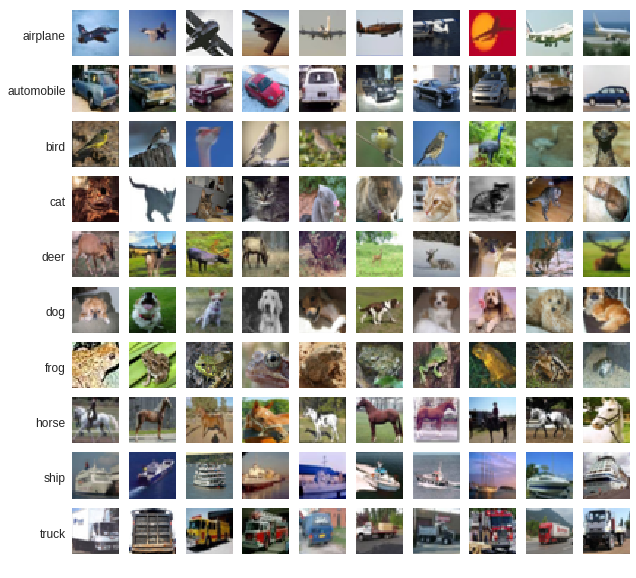

In [38]:
from vis_utils import plot_sample

plot_sample(X_train, y_train, label_names)

### Baseline
As a baseline, we convert images to grayscale, extract HOG features and train a linear SVM on top of them.

In [ ]:
import skimage.data
from skimage import data, color, feature
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

from vis_utils import plot_sample_hog_features

Let's plot a sample of CIFAR-10 images and their corresponding HOG features.

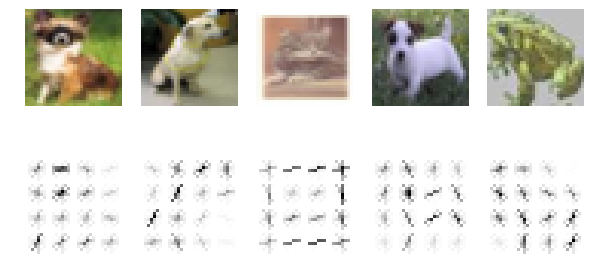

In [53]:
plot_sample_hog_features(X_train)

In [ ]:
def img_to_hog(data):
    data_gray = [color.rgb2gray(data[i]) for i in range(data.shape[0])]
    hog = lambda x: feature.hog(x, visualise=False, block_norm='L2-Hys')
    data_hog = [hog(data_gray[i]) for i in range(data.shape[0])]
    return np.array(data_hog)

Since we won't be tuning the performance of our baseline classifier, it's enough to train it on the train data and report it's performance on the test data (ie we don't need to use validation data here).

In [ ]:
X_train_hog = img_to_hog(X_train)
X_test_hog = img_to_hog(X_test)

In [56]:
print(f'X_train_hog shape: {X_train_hog.shape}')
print(f'X_test_hog shape: {X_test_hog.shape}')

X_train_hog shape: (40000, 324)
X_test_hog shape: (10000, 324)


Let's train a linear SMV with default parameters.

In [60]:
baseline_svm = LinearSVC()
with Timer():
    baseline_svm.fit(X_train_hog, y_train)

Elapsed: 464.02 seconds. 



Notice that classes in CIFAR-10 are balanced, hence accuracy is an appropriate measure of success. As stated earlier, we won't be wasting time on tuning basesline classifier's performance, hence let's just report its test set accuracy.

In [62]:
y_pred = baseline_svm.predict(X_test_hog)
acc = accuracy_score(y_test, y_pred)
print(f'Baseline accuracy is {acc}')

Baseline accuracy is 0.4604


Notice that our datasets is balanced and consists of 10 classes, thus random classifier would have an accuracy of 10%. Hence, our baseline performs better than a random classifier. It is far from being satisfactory, though.

### Feature extraction using pretrained CNN
Having established the baseline, we can move on to transfer learning. We will use ImageNet-pretrained ResNet50* as our feature extractor.  We will carry out the following steps:
* feature extraction and visualisation of CNN codes
* training an SVM on top of CNN codes (with hyperparameter optimisation)
* adding Dense layers on top of pretrained ResNet and fine-tuning the network (using dropout/data augmentation for regularisation)







\* We also experimented with InecptionV3 but obtained roughly 10% worse accuracy than ResNet50.

We will use the  pretrained network from Keras.

For preprocessing, we will resize our input images to match the size expected by ResNet and use caffe-style preprocessing, ie we will center the images with mean learned on ImagNet, but we will not do scaling.

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet_preprocessor
from keras.layers import Reshape
from keras.models import Model
from sklearn.utils import shuffle as sk_shuffle

from utils import resize_images

def data_generator(
    X, y, batch_size, target_size=(224, 224, 3), 
    preprocessor=resnet_preprocessor, shuffle=False):
    
    start = 0
    end = start + batch_size
    n = X.shape[0]
    if shuffle:
        X, y = sk_shuffle(X, y)
    while True:
        X_batch = X[start : end]
        y_batch = y [start : end]
        
        X_resized = resize_images(X_batch, target_size)
        X_preprocessed = preprocessor(X_resized)

        start += batch_size
        end   += batch_size
        if start >= n:
            start = 0
            end = batch_size
            if shuffle:
                X, y = sk_shuffle(X, y)
        yield (X_preprocessed, y_batch)

def resnet50_feature_extractor():
    model = ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(224, 224,3))
    # Reshape to squash empty dimensions
    output = Reshape((2048,))(model.output)
    return Model(model.input, output)

In [92]:
resnet = resnet50_feature_extractor()

batch_size = 40
cnn_codes_train = resnet.predict_generator(
    data_generator(
        X_train, y_train, batch_size=batch_size), 
        X_train.shape[0] / batch_size, verbose=1)
cnn_codes_val = resnet.predict_generator(
    data_generator(
        X_val, y_val, batch_size=batch_size), 
        X_val.shape[0] / batch_size, verbose=1)
cnn_codes_test = resnet.predict_generator(
    data_generator(
        X_test, y_test, batch_size=batch_size), 
        X_test.shape[0]/ batch_size, verbose=1)

94658560/94653016 [==============================] - 9s 0us/step


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


250/250 [==============================] - 130s 520ms/step


In [93]:
# size check:
print(cnn_codes_train.shape)
print(cnn_codes_val.shape)
print(cnn_codes_test.shape)

(40000, 2048)
(10000, 2048)
(10000, 2048)


In [ ]:
# save data
np.save('cnn_codes_train.npy', cnn_codes_train) 
np.save('cnn_codes_val.npy', cnn_codes_val)
np.save('cnn_codes_test.npy', cnn_codes_test)

### PCA visualisation of CNN codes
We will use PCA to project our newly extracted CNN codes to 2D and visualise them. To save time, we will use test data (ie only 10k samples).

In [ ]:
from sklearn.decomposition import PCA

from vis_utils import plot_projection

pca = PCA()
cnn_codes_pca_proj = pca.fit_transform(cnn_codes_test)

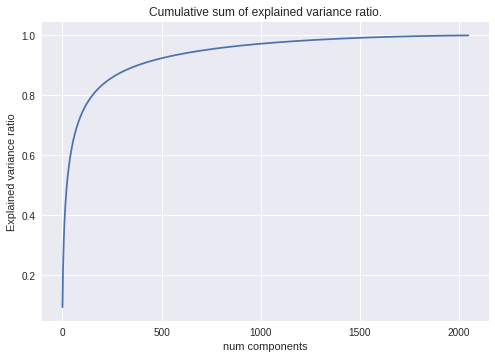

In [103]:
plt.plot(range(2048), np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative sum of explained variance ratio.')
plt.xlabel('num components')
plt.ylabel('Explained variance ratio');

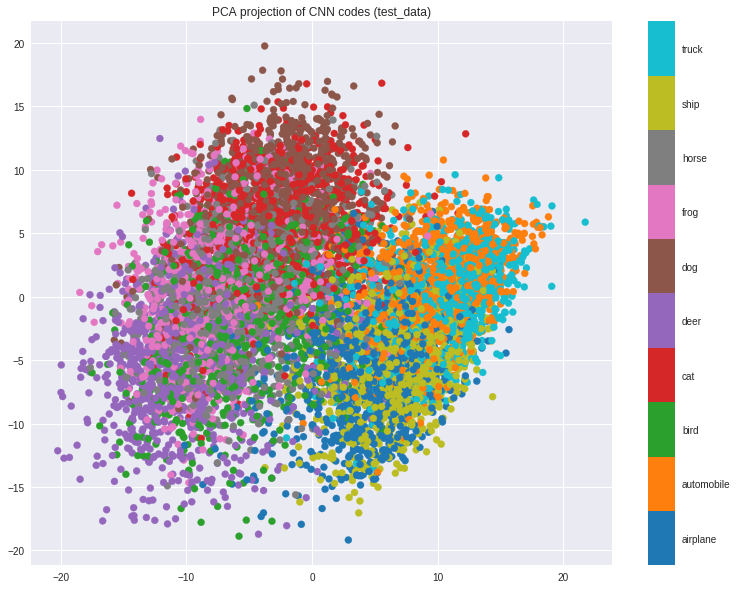

In [104]:
cnn_codes_pca_proj = cnn_codes_pca_proj[:, :2]
plot_projection(cnn_codes_pca_proj, y_test, label_names, 'PCA projection of CNN codes (test_data)')

In [105]:
print(f'Two largest components of PCA projectionc explain {sum(pca.explained_variance_ratio_[:2]) * 100:.2f}% of variance in data.')

Two largest components of PCA projectionc explain 14.77% of variance in data.


Not that even, even though first two components of PCA explain only about 15% of variance in data, we already see that in our CNN codes dogs are close to cats, deers are close to horses and automobiles are close to trucks. Thus the features learned by ResNet50 on ImageNet transfer rather well to our task.

### t-SNE visualisation

To obtain an even better visualisation of CNN codes, we will use t-SNE. This algorithm is designed to project high-dimensional data to 2 or 3 dimensions in a way that preserver 'closeness' of points, ie points which are close in high-dimensional space will remain close in the projection, and similarly points which are far in the original space will remain far in the projection. Note however that t-SNE does not preserve distances. Unlike PCA, t-SNE is not a linear projection. A good resource on t-SNE is https://distill.pub/2016/misread-tsne/ - following its advice, we will check three different values of perplexity to get a better insight into the distribution of CNN codes.

Since t-SNE is expensive computationally, we will first reduce the dimensionality of our dataset using PCA. Using a plot above, we see that by reducing dimensionality of the data four times (from 2048 to around 500 components), we still retain ~80% of variance in data



In [ ]:
pca = PCA(n_components=0.8)
pca_proj_test = pca.fit_transform(cnn_codes_test)

In [78]:
from sklearn.manifold import TSNE

# default perplexity of 30
with Timer():
    print('Fitting t-SNE with perplexity = 30.')
    tsne_30 = TSNE(2)
    cnn_codes_tsne_30 = tsne_30.fit_transform(pca_proj_test)
    np.save('tsne_30', cnn_codes_tsne_30)
    print('Done.')

# perplexity = 50
with Timer():
    print('Fitting t-SNE with perplexity = 50')
    tsne_50 = TSNE(2, perplexity=50)
    cnn_codes_tsne_50 = tsne_50.fit_transform(pca_proj_test)
    np.save('tsne_50', cnn_codes_tsne_50)
    print('Done.')

# perplexity = 100
with Timer():
    print('Fitting t-SNE with perplexity = 100')
    tsne_100 = TSNE(2, perplexity=100)
    cnn_codes_tsne_100 = tsne_100.fit_transform(pca_proj_test)
    np.save('tsne_100', cnn_codes_tsne_100)

Fitting t-SNE with perplexity = 30.
Done.
Elapsed: 290.83 seconds. 

Fitting t-SNE with perplexity = 50
Done.
Elapsed: 357.32 seconds. 

Fitting t-SNE with perplexity = 100
Elapsed: 540.99 seconds. 



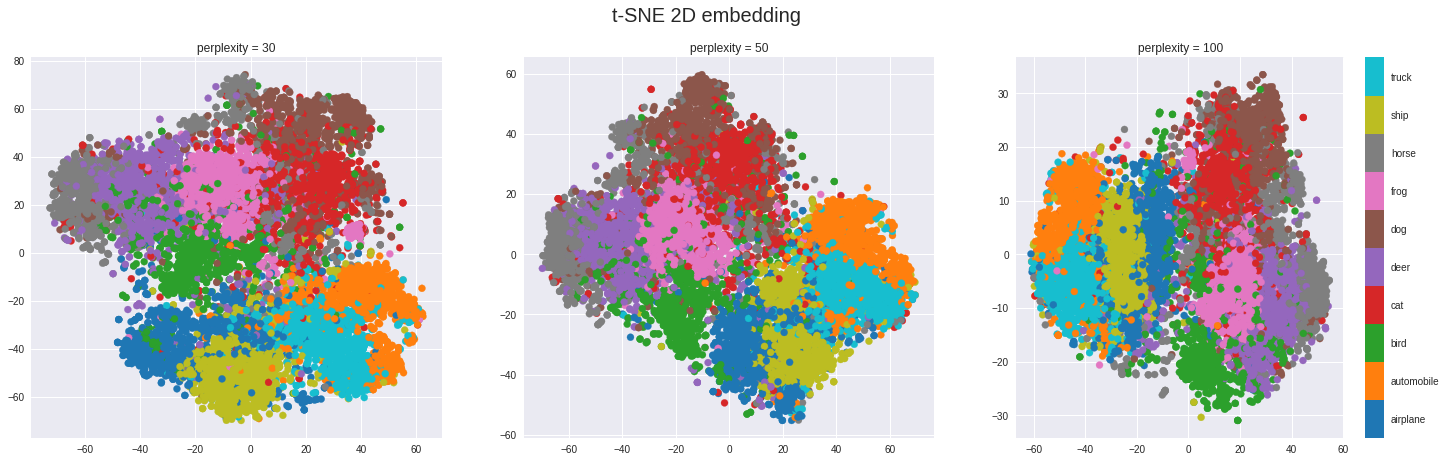

In [79]:
from vis_utils import plot_multiple_tsne_embeddings

plot_multiple_tsne_embeddings(
    cnn_codes_tsne_30, 
    cnn_codes_tsne_50, 
    cnn_codes_tsne_100, 
    y_test, label_names)

This time the trend already observed in PCA projection is even more pronounced. Deers are close to horses, cats are close to dogs, trucks are close to cars. Moreover, each class creates a more or less homogenous cluster. This bodes well for using these features extracted using pretrained ResNet50 for our task.

### Linear SVM on top of CNN codes

We will now train a linear SVM on top of CNN codes. We will find the optimal value of regualrisation parameter C via grid search.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
X_train = cnn_codes_train
X_val = cnn_codes_val
X_test = cnn_codes_test

In [ ]:
def grid_search_svm(
    X_train, y_train, 
    X_val, y_val, model, 
    C_vals=[0.0001, 0.001, 0.01, 0.1, 1]
):
    
    results = []
    best_model = None
    best_val_acc = 0 

    with Timer():
        for c in C_vals:
            with Timer():
                svm = model(C=c)
                print(f'Fitting SVM with C={c}')
                svm.fit(X_train, y_train)
                print('Done.')

                y_pred_train = svm.predict(X_train)
                y_pred_val = svm.predict(X_val)
                train_acc = accuracy_score(y_train, y_pred_train)
                val_acc = accuracy_score(y_val, y_pred_val)

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model = svm

                current_result = {'C': c, 'train_acc': train_acc, 'val_acc': val_acc}
                results.append(current_result)
                print(f'Current results are: {current_result}')
    
    return results, best_model

In [26]:
linear_svm_results, best_model = grid_search_svm(X_train, y_train, X_val, y_val, LinearSVC)

Fitting SVM with C=0.0001
Done.
Current results are: {'C': 0.0001, 'train_acc': 0.9147, 'val_acc': 0.903}
Elapsed: 15.66 seconds. 

Fitting SVM with C=0.001
Done.
Current results are: {'C': 0.001, 'train_acc': 0.944775, 'val_acc': 0.9161}
Elapsed: 25.87 seconds. 

Fitting SVM with C=0.01
Done.
Current results are: {'C': 0.01, 'train_acc': 0.970525, 'val_acc': 0.9111}
Elapsed: 97.18 seconds. 

Fitting SVM with C=0.1
Done.
Current results are: {'C': 0.1, 'train_acc': 0.987075, 'val_acc': 0.8975}
Elapsed: 168.08 seconds. 

Fitting SVM with C=1
Done.
Current results are: {'C': 1, 'train_acc': 0.984625, 'val_acc': 0.8826}
Elapsed: 178.29 seconds. 

Elapsed: 485.08 seconds. 



In [28]:
linear_svm_results

[{'C': 0.0001, 'train_acc': 0.9147, 'val_acc': 0.903},
 {'C': 0.001, 'train_acc': 0.944775, 'val_acc': 0.9161},
 {'C': 0.01, 'train_acc': 0.970525, 'val_acc': 0.9111},
 {'C': 0.1, 'train_acc': 0.987075, 'val_acc': 0.8975},
 {'C': 1, 'train_acc': 0.984625, 'val_acc': 0.8826}]

The best validation accuracy of 0.9161 was obtained for C = 0.001.  W clearly see that higher values of C lead to overfitting (Notice that in sklearn implementation C is inversly proportional to strength of regularisation, ie higher C means less regularisation)

Finally, let's see the performance of out best model on test data.

In [97]:
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Test set accuracy is {acc}.')

Test set accuracy is 0.9145.


We can also retrain the best model on both training and validation data to further boost its performance on test set.

In [ ]:
cnn_codes = np.concatenate([X_train, X_val])
y = np.concatenate([y_train, y_val])
cnn_codes, y = sk_shuffle([cnn_codes, y])

In [101]:
svm = LinearSVC(C=0.001)
svm.fit(cnn_codes, y)
y_pred = svm.predict(cnn_codes_test)
acc = accuracy_score(y_test, y_pred)
print(f'Test set accuracy is {acc}.')

Test set accuracy is 0.9179.


### FINE TUNING
We will now fine tune ResNet50. We begin by adding Dense classifier on top of frozen ResNet base and training it until good performnce is achieved. We then unfreeze stage 5 of ResNet and train further with a small learning rate to fine tune the final convolutional layers of ResNet to CIFAR-10.

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

In [ ]:
def dense_model(hidden_units=1024, dropout_rate=0.5):
    model = Sequential()
    model.add(Dropout(dropout_rate, input_shape=(2048,)))
    model.add(Dense(hidden_units, activation='relu', input_shape=(2048,)))
    model.add(Dense(10, activation='softmax'))
    return model

Training a Dense network on top frozen ResNet is equivalent to trainig a Dense network on top of CNN codes extracted using ResNet. First, train the network without regularisation.

In [ ]:
model = dense_model(dropout_rate=0.0)
model.compile(
    optimizer=Adam(lr=1e-3), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

# loss is sparse_categorical_crossentropy because we didn't convert labels to one-hot

In [120]:
batch_size = 32

history = model.fit(
    cnn_codes_train, y_train,
    batch_size=batch_size,
    epochs=10,
    validation_data=(cnn_codes_val, y_val),
)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 10s 253us/step - loss: 0.3915 - acc: 0.8670 - val_loss: 0.3003 - val_acc: 0.8970
Epoch 2/10
40000/40000 [==============================] - 9s 230us/step - loss: 0.2615 - acc: 0.9101 - val_loss: 0.2691 - val_acc: 0.9079
Epoch 3/10
40000/40000 [==============================] - 9s 228us/step - loss: 0.2068 - acc: 0.9272 - val_loss: 0.2778 - val_acc: 0.9061
Epoch 4/10
40000/40000 [==============================] - 9s 230us/step - loss: 0.1685 - acc: 0.9405 - val_loss: 0.2954 - val_acc: 0.9015
Epoch 5/10
40000/40000 [==============================] - 9s 230us/step - loss: 0.1345 - acc: 0.9515 - val_loss: 0.3280 - val_acc: 0.9030
Epoch 6/10
40000/40000 [==============================] - 9s 229us/step - loss: 0.1034 - acc: 0.9621 - val_loss: 0.3153 - val_acc: 0.9089
Epoch 7/10
40000/40000 [==============================] - 9s 231us/step - loss: 0.0800 - acc: 0.9720 - val_loss: 0.3620 -

Notice that we are able to easily overfit the network. Let's add dropout between the output of feature extractor and the first Dense layer to regularise the network.

In [55]:
model = dense_model(dropout_rate=0.5)

model.compile(
    optimizer=Adam(lr=1e-4), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

batch_size = 32

history = model.fit(
    cnn_codes_train, y_train,
    batch_size=batch_size,
    epochs=50,
    validation_data=(cnn_codes_val, y_val),
    callbacks=[ModelCheckpoint('dense_top_with_dropout.h5', monitor='val_acc', save_best_only=True)]
)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 11s 274us/step - loss: 0.5425 - acc: 0.8146 - val_loss: 0.3237 - val_acc: 0.8880
Epoch 2/50
40000/40000 [==============================] - 10s 255us/step - loss: 0.3871 - acc: 0.8653 - val_loss: 0.2874 - val_acc: 0.9027
Epoch 3/50
40000/40000 [==============================] - 10s 253us/step - loss: 0.3571 - acc: 0.8757 - val_loss: 0.2924 - val_acc: 0.8984
Epoch 4/50
40000/40000 [==============================] - 10s 254us/step - loss: 0.3365 - acc: 0.8825 - val_loss: 0.2745 - val_acc: 0.9062
Epoch 5/50
40000/40000 [==============================] - 10s 254us/step - loss: 0.3184 - acc: 0.8872 - val_loss: 0.2665 - val_acc: 0.9094
Epoch 6/50
40000/40000 [==============================] - 10s 254us/step - loss: 0.3043 - acc: 0.8920 - val_loss: 0.2586 - val_acc: 0.9117
Epoch 7/50
40000/40000 [==============================] - 10s 255us/step - loss: 0.2937 - acc: 0.8956 - val_loss: 0.

We are still overfitting, but managed to improve validation accuracy. Let's look at accuracy and loss plots and check the performance on the test data.

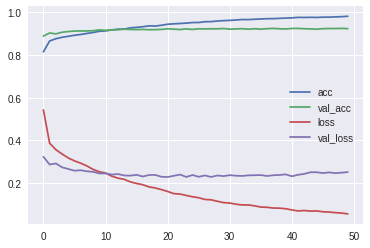

In [59]:
from vis_utils import plot_loss_and_acc
plot_loss_and_acc(history)

In [63]:
from keras.models import load_model

best_model = load_model('dense_top_with_dropout.h5')
best_model.evaluate(cnn_codes_test, y_test)

10000/10000 [==============================] - 1s 105us/step


[0.2535573269158602, 0.9217]

We see that we already improved test set accuracy to 0.9217

### Discussion of Keras' Batch Norm layer 

Before we start fine tuning the network, we need to highlight certain aspects of Keras' implementation of BatchNorm which make it unsuitable for transfer learning. We will demonstrate the issue, link to resources discussing it in more details, discuss the workaround used and finally proceed to fine tuning the network.

First, note that BatchNorm is a layer which exhibits different behaviour in training and in testing. Whether a given network is currently in training or in test phase is controlled by Keras backed attribute `learnig_phase`. Learning phase of 0 means testing, learning phase of 1 means traning. Thus, when we run `.fit` on a network, it's learning phase is set to 1 and BatchNorm uses batch statistis for normalisation. If we then want to make predictions with the network and invoke `.predict` method, `learningh_pase` will be set to 0 and BatchNorm will use exponentially weighted moving average of mean and std learned on batches during training.

**The problem with BatchNorm layer of Keras lies in its behaviour when frozen (ie when parameter `trainable` is set to `False`). Although neither the weights, nor the exponentially weighted moving average of batch mean and std are updated when learning phase is 1, Keras' BatchNorm still uses batch statistics to normalise its input.** Why is that a problem? If all other layers around BatchNorm are frozen (and trained on a different dataset, say, ImageNet), then they 'expect' input data (ie output of BatchNorm layer) to be coming from certain distribution/range. Exponentially weighted average of mean and std of batches of ImageNet might be very different from current mini-batch statistics, thus if in training we subtract current mini-batch statistis instead of the ones learned on ImageNet we are essentially causing covariate shift that BatchNorm was meant to prevent! Since the layer immediately after BN is frozen it can't update its weights to accommodate different normalising statistics of mini-batch of our dataset (different than ImageNet). **Essentially, when frozen, we would like BatchNorm to behave as if it was in testing, ie in learning phase 0. This is not its behaviour in Keras.**

This issue has been pointed out multiple times in Keras' github issues and there has been a (rejected) pull request to change BN behaviour when frozen to the one described above.  In these issues, it is noted that current BN behaviour in Keras results in descreased transfer learning performance. The PR was rejected mainly due to lack of compromise on the semantics of the word `trainable` and because there are hacks around this behaviour already present in Keras API. We will discuss them shortly.


For a more comprehensive breakdown of the issue please visit the following:
* https://github.com/keras-team/keras/pull/9965 - pull request
* http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/ - blog post discussing above PR and current Keras behaviour in detail, together with benchmarks and proposed soluton
* https://github.com/keras-team/keras/issues/9214 - fine tuning of networks containing BNs doesn't work, some possible solutions in the comments
* https://github.com/keras-team/keras/issues/4762 - more of the same, older
* https://github.com/keras-team/keras/issues/4674 - more of the same, older



To demonstrate the behaviour of BN in Keras, let's perform a simple experiment. We have already extracted CNN codes using ResNet with `.predict_generator` method, ie with `learning_phase=0`. Let's extract the same codes using `fit_generator` ie with `learnig_phase=1` and compare output. We will see that the output is not the same.

In [ ]:
# read the data again as it was overwritten
X_train, y_train, X_val, y_val, X_test, y_test, label_names = read_and_reshape_cifar10()

In [ ]:
def test_model():
    model = ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(224,224, 3))
    output = Reshape((2048,))(model.output)
    return Model(model.input, output)

In [129]:
demo_model = test_model()

# freeze all layers to prevent weights from updating despite running .fit on the model
for layer in demo_model.layers:
    layer.trainable=False
    
batch_size=32    
demo_model.compile(Adam(lr=1e-3), 'mse')
demo_model.fit_generator(
    data_generator(
        X_train, cnn_codes_train, batch_size=batch_size, shuffle=False),
    steps_per_epoch=math.ceil(X_train.shape[0] / batch_size), 
    epochs=1, 
    verbose=1)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1250/1250 [==============================] - 451s 361ms/step - loss: 0.5791


We froze all the layers of our ResNet and used `.fit_generator` to extract CNN codes from trainig data. We compared the output with the CNN codes extracted using `.predict_generator` using MSE and they were not the same. This demonstrates the discussed issue - when using `.fit_generator` network was running in training phase and BN used mini-batch statistics for its normalisation step, wheras when using `.predict_generator` BN used exponentially weighted average of mini-batch statistics of ImageNet.

In [ ]:
from keras import backend as K

def test_model_learning_phase_0():
    K.set_learning_phase(0)
    model = ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(224,224, 3))
    output = Reshape((2048,))(model.output)
    return Model(model.input, output)

In [131]:
demo_model = test_model_learning_phase_0()

# freeze all layers to prevent weights from updating despite running .fit on the model
for layer in demo_model.layers:
    layer.trainable=False
    
batch_size=32    
demo_model.compile(Adam(lr=1e-3), 'mse')
demo_model.fit_generator(
    data_generator(
        X_train, cnn_codes_train, batch_size=batch_size, shuffle=False),
    steps_per_epoch=math.ceil(X_train.shape[0] / batch_size), 
    epochs=1, 
    verbose=1)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Epoch 1/1
1250/1250 [==============================] - 493s 394ms/step - loss: 5.2939e-13


Notice that now we obtain the same CNN codes (ie MSE = 0 up to rounding erros ), since regardless of which function we used (`fit` or `predict`) we forced to model to operate in learning phase 0.

Notice however that setting learning phase to 0 for ResNet and then setting it to 1 for the Dense top won't do the trick for us - we want to run part of ResNet (stages 1 - 4) in learning phase 0 (ie all frozen, including BN) and stage 5 in learning phase 1. Thus we can't use ResNet50 model from `keras.applications`, as we can't set separate learning phase for its different parts.

The way around this was proposed in one of the linked github issues by F. Chollet. The `.call` method of Keras layers have an argument `training`. If set to False, it forces the layer to operate in test mode, ie as if learnig phase was set to 0. Thus, we need to rewrite the code producing ResNet50 but adding an extra argument to it which will allow to us to control `training` parameter of `.call` method of any given BN layer. This is precisely what was done by Broad Institute in their Keras implementation of ResNet for transfer learning: https://github.com/broadinstitute/keras-resnet

Instead of using their implementation, we took ResNet50 code from keras applications: https://github.com/keras-team/keras-applications and replaced every BN layer with freezable BN layer as in Broad Institute's keras-resnet repo (ie we explicitely added `freeze` parameter to BN `__init__` which controls whether `.call` is called with `training` set to true or false).  The code can be found in the `custom_resnet` directory. It's a slimmed down verison of keras applications code (only necessary functions where left) togehter with freezable BN from Broad Institute.

To recap: with that custom implementation of ResNet we are able to load ImageNet weights and force whichever BN layer we want to operate in testing phase, while keeping other BN layers operating in training phase. This is precisely what we need to fine tune stage 5 of ResNet.

### Fine tuning ResNet50

In [ ]:
from custom_resnet.modified_resnet import FreezableResNet50

In [ ]:
best_model = load_model('dense_top_with_dropout.h5')

def resnet_for_fine_tuning():
    model = Sequential()
    model.add(
        FreezableResNet50(
        weights='imagenet', 
        include_top=False, 
        freeze_bn=True,  # notice this argument
        input_shape=(224, 224, 3)))
    # instead of Reshape; our custom ResNet is based on code from later 
    # Keras version than used in the rest of the notebook
    model.add(GlobalAveragePooling2D())  
    model.add(best_model)
    return model

In [83]:
model = resnet_for_fine_tuning()

/content/modified_resnet.py:278: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
# freeze all layers up to stage 5
# note BN is already frozen (ie running in test phase)

for layer in model.layers[:143]:
    layer.trainable=False

# unfreeze BN layers from stage 5
for layer in model.layers[143:]:
    if 'bn' in layer.name:
        layer.freeze=False

In [ ]:
model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [95]:
batch_size = 32

history = model.fit_generator(
    data_generator(X_train, y_train, batch_size=batch_size, shuffle=True), 
    steps_per_epoch=math.ceil(X_train.shape[0] / batch_size), 
    epochs=20, 
    verbose=1,
    validation_data=data_generator(X_val, y_val, batch_size=batch_size),
    validation_steps=math.ceil(X_val.shape[0] / batch_size),
    callbacks=[ModelCheckpoint('fine_tuned_resnet.h5', monitor='val_acc', save_best_only=True)]
)

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1250/1250 [==============================] - 606s 485ms/step - loss: 0.1704 - acc: 0.9396 - val_loss: 0.3312 - val_acc: 0.9002
Epoch 2/20
1250/1250 [==============================] - 600s 480ms/step - loss: 0.1717 - acc: 0.9402 - val_loss: 0.3312 - val_acc: 0.9002
Epoch 3/20
1250/1250 [==============================] - 605s 484ms/step - loss: 0.1737 - acc: 0.9389 - val_loss: 0.3312 - val_acc: 0.9002
Epoch 4/20
1250/1250 [==============================] - 596s 477ms/step - loss: 0.1732 - acc: 0.9395 - val_loss: 0.3312 - val_acc: 0.9002
Epoch 5/20
1250/1250 [==============================] - 597s 478ms/step - loss: 0.1732 - acc: 0.9386 - val_loss: 0.3312 - val_acc: 0.9002
Epoch 6/20
1250/1250 [==============================] - 595s 476ms/step - loss: 0.1760 - acc: 0.9377 - val_loss: 0.3312 - val_acc: 0.9002
Epoch 7/20
1250/1250 [==============================] - 595s 476ms/step - loss: 0.1717 - acc: 0.9394 - val_loss: 0.3312 - val_acc: 0.9002
Epoch 8/20
1250/1250 [=======================

KeyboardInterrupt: ignored

We stopped the training as it wasn't really going anywhere. Also, notice that validation accuracy wasn't the true validation accuracy as BN layers from stage 5 were forced to always operate in training mode, ie alwasy use mini-batch statistics, even when validating.

Let us demonstrate that using regular Keras' ResNet wouldn't help and is not suitable for transfer learning.

In [ ]:
best_model = load_model('dense_top_with_dropout.h5')

In [ ]:
def fine_tune_resnet_done_wrong():
    model = Sequential()
    model.add(ResNet50(
        weights='imagenet', 
        input_shape=(224, 224, 3), 
        include_top=False))
    model.add(Reshape((2048,)))
    model.add(best_model)
    return model

In [ ]:
demo_model = fine_tune_resnet_done_wrong()

for layer in demo_model.layers[:143]:
    layer.trainable=False
    
demo_model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [110]:
batch_size = 32

history = demo_model.fit_generator(
    data_generator(X_train, y_train, batch_size=batch_size, shuffle=True), 
    steps_per_epoch=math.ceil(X_train.shape[0] / batch_size), 
    epochs=20, 
    verbose=1,
    validation_data=data_generator(X_val, y_val, batch_size=batch_size),
    validation_steps=math.ceil(X_val.shape[0] / batch_size),
    callbacks=[ModelCheckpoint('fine_tuned_resnet.h5', monitor='val_acc', save_best_only=True)]
)

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1250/1250 [==============================] - 585s 468ms/step - loss: 2.4348 - acc: 0.5678 - val_loss: 0.2494 - val_acc: 0.9242
Epoch 2/20
1250/1250 [==============================] - 572s 458ms/step - loss: 2.4101 - acc: 0.5700 - val_loss: 0.2494 - val_acc: 0.9242
Epoch 3/20
1250/1250 [==============================] - 588s 470ms/step - loss: 2.4370 - acc: 0.5701 - val_loss: 0.2494 - val_acc: 0.9242
Epoch 4/20
1250/1250 [==============================] - 573s 458ms/step - loss: 2.4034 - acc: 0.5718 - val_loss: 0.2494 - val_acc: 0.9242
Epoch 5/20
 630/1250 [==============>...............] - ETA: 3:43 - loss: 2.4175 - acc: 0.5647

KeyboardInterrupt: ignored

We see that although validation accuracy is correct (ie the same as best_model), trainig accuracy is completely wrong. This is due to discussed Keras' BN behaviour in training phase.

### DATA AUGMENTATION
Finally, let's try data augmentation to further improve performance.

To begin with, we visualise a sample of randomly augmented images.

/Users/Przemek/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


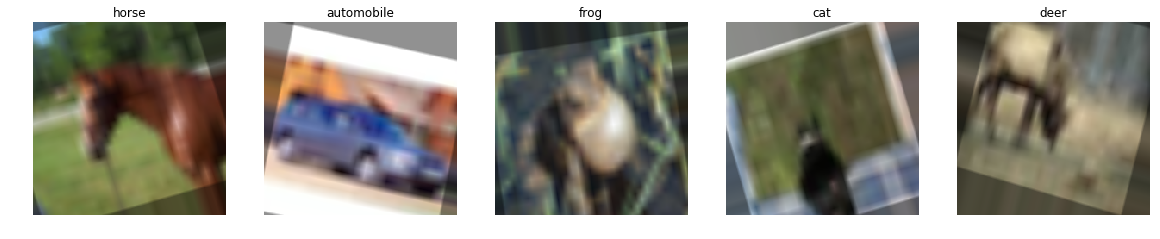

In [5]:
from vis_utils import plot_sample_augmented

plot_sample_augmented(X_train, y_train, label_names)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def data_generator_with_augmentation(
    X, y, batch_size, 
    target_size=(224, 224, 3), 
    preprocessor=resnet_preprocessor,
    shuffle=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,  
):
    start = 0
    end = start + batch_size
    n = X.shape[0]
    if shuffle:
        X, y = sk_shuffle(X, y)
    
    augmenter = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
    )
    
    while True:
        X_batch = X[start : end]
        y_batch = y [start : end]
        
        X_resized = resize_images(X_batch, target_size)
        X_augmented = np.array(
            [augmenter.random_transform(x) for x in X_resized])
        X_preprocessed = preprocessor(X_augmented)

        start += batch_size
        end   += batch_size
        if start >= n:
            start = 0
            end = batch_size
            if shuffle:
                X, y = sk_shuffle(X, y)
        yield (X_preprocessed, y_batch)

In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D

def resnet50_freezable():
    model = FreezableResNet50(
        weights='imagenet', 
        include_top=False, 
        freeze_bn=True,
        input_shape=(224, 224, 3),
    )
    reshaped_tensor = GlobalAveragePooling2D()(model.output)
    x = Dense(1024, activation='relu')(reshaped_tensor)
    output = Dense(10, activation='softmax')(x)
    return Model(model.input, output)

In [144]:
model = resnet50_freezable()

# freeze convolutional base
for layer in model.layers:
    if 'dense' in layer.name:
        layer.trainable=True
    else:
        layer.trainable=False
        
# check if frozen correctly
model.trainable_weights

/content/custom_resnet/modified_resnet.py:278: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


[<tf.Variable 'dense_9/kernel:0' shape=(2048, 1024) dtype=float32_ref>,
 <tf.Variable 'dense_9/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'dense_10/kernel:0' shape=(1024, 10) dtype=float32_ref>,
 <tf.Variable 'dense_10/bias:0' shape=(10,) dtype=float32_ref>]

In [ ]:
model.compile(optimizer=Adam(lr=1e-7), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 32

history = model.fit_generator(
    data_generator_with_augmentation(
        X_train, y_train, batch_size=batch_size, shuffle=True), 
    steps_per_epoch=math.ceil(X_train.shape[0] / batch_size), 
    epochs=20, 
    verbose=1,
    validation_data=data_generator(X_val, y_val, batch_size=batch_size),
    validation_steps=math.ceil(X_val.shape[0] / batch_size),
    max_queue_size=64,
)

The network above was trained for around 30 epochs. Learning rate was manually tuned every few epochs, starting from 1e-3 and going all the way down to 1e-7. Traing accuracy was slowly gowing up to around 0.95 while validation accuracy stayed around 0.915-0.920. We thus see that data augmentation provided very strong regularisation. (We kept stopping the execution of the cell, lowering the learning rate, recompiling the model and resuming the execution. We then stopped midway through trainig when there was no more hope for improvement. We thus suppress the ouput of that cell for clarity.)

Let's test the trained network.

In [92]:
batch_size = 32

y_pred = model.predict_generator(
    data_generator(X_test, y_test, batch_size=batch_size, shuffle=False), 
    steps=math.ceil(X_test.shape[0] / batch_size), 
    verbose=1,
)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


313/313 [==============================] - 134s 430ms/step


In [104]:
test_acc = accuracy_score(y_test, np.argmax(y_pred, axis=1))
print(f'Test acc: {test_acc}')

Test acc: 0.9152


In [ ]:
for layer in model.layers[143:]:
    layer.trainable = True
    if 'bn' in layer.name:
        layer.freeze = False

Let's try fine tuning stage 5 of the network.

In [ ]:
model.compile(Adam(lr=1e-8), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 32

history = model.fit_generator(
    data_generator_with_augmentation(
        X_train, y_train, batch_size=batch_size, shuffle=True), 
    steps_per_epoch=math.ceil(X_train.shape[0] / batch_size), 
    epochs=5, 
    verbose=1,
    validation_data=data_generator(X_val, y_val, batch_size=batch_size),
    validation_steps=math.ceil(X_val.shape[0] / batch_size),
    max_queue_size=64,
)

The network above was trained for another 10 epochs but performance stayed very similar to before. Unfortunately the output was accidentally overwritten.

In [ ]:
# freeze BN layers from stage 5 for prediction
for layer in model.layers[143:]:
    if 'bn' in layer.name:
        layer.freeze=False

In [ ]:
batch_size = 32

y_pred = model.predict_generator(
    data_generator(X_test, y_test, batch_size=batch_size, shuffle=False), 
    steps=math.ceil(X_test.shape[0] / batch_size), 
    verbose=1,
)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


  1/313 [..............................] - ETA: 24:30

In [124]:
test_acc = accuracy_score(y_test, np.argmax(y_pred, axis=1))
print(f'Test acc: {test_acc}')

Test acc: 0.9174


We observer a marginal accuracy improvement after fine tuning stage 5. Still, better accuracy was obtained using Dropout as regularizer.

### SUMMARY

We trained a number of classifier on CIFAR-10 dataset. Our baseline approach of extracting HOG features and training a linear SVM on top of them yielded a poor accuracy of 0.46. We improved on that by extracting CNN features with ResNet50 pretrained on ImageNet. A tuned linear SVM on top of these CNN features yielded an accuracy of 0.9179. We improved on that result by training a regularized fully connected network on top of CNN features, yielding an **accuracy of 0.9217. This was the best test set accuracy obtained in our experiments.** Further attempts to improve that accuracy by fine tuning stage 5 of ResNet and using data augmentation yielded only a slight improvement over a linear SVM.

Along the way, we produced a number of visualisations of the data and its various transformations.

Finally, in due course, we discovered an unexpected and potentially harmful behaviour of Keras' BatchNorm layer when used in transfer learning setting. We pointed out to blog posts and Github issues discussing the problem in detail and discussed and utilised a possible workaround.